## EDA - Predicted Explanation Quality

This notebook analyses the post-run data obtained from predictions generated by the eSNLI pre-trained model to determine the quality of the generated explanations.

Inside Section 3 of the e-SNLI Paper, the original writers described a scoring method that they use for determining if an explanation is correct, as well as a way to filter out uninformative and thus incorrect explanations. A brief summary of what that section says is found here:

What is Section 3 Partial Scoring Method

* To measure the quality of the explanations, grade the correctness between 0 and 1. 
* Give partial score of k / n if only k out of n required arguments are measured. (What are required arguments - Not applicable for us)
* Consider explanation incorrect if explanation is uninformative. Examples:
	- Explanation is template-like, extensively repeating details from premise/hypothesis not useful for JUSTIFYING THE RELATION between the 2 sentences
		* EXAMPLE: (neutral) “Just because [entire premise] doesn’t mean [entire hypothesis]”
		* EXAMPLE 2: (entailment) “[entire premise] implies [entire hypothesis]”
		* EXAMPLE 3: (contradiction) "It can either be [entire premise] or [entire hypothesis]"
		* These examples don't contain any useful information about the relation between the 2 sentences. Other templates found in Appendix A which I will send a pic of.
	- Filter if edit distance to one of these templates is less than 10.

The part that we want to focus on first is filtering out the explanations where the edit distance to one of those templates is less than 10.

### What type of Minimum Edit Distance to Use?

We will use *Levenshtein distance*, as it allows deletion, insertion and substitution but not transposition, which is what was taught in CS4248 lectures. We would also use a MED of 15 instead of 10 to account for the possibility of more noise.

### Method

1. Iterate through every row. 
1. For each row, compile a list of sentences to compare the generated explanation to. The sentence list contains the premise and hypothesis of that row compiled together with the list of templates in the original paper's Appendix A. If the row is for entailment, we include the entailment templates as well. We can do something similar for contradiction and neutral if we come up with our own templates.
1. Iterate through this template sentence list and for each template sentence, calculate the minimum *Levenshtein distance* between that sentence and the generated explanation.
1. If for any one of these sentences the MED is less than 15, we discard the row, otherwise we add that row to a new CSV file that we will use for further human evaluation.


In [7]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import textdistance as td
# import seaborn as sns
pd.set_option('display.max_colwidth', None)
from sklearn.metrics import confusion_matrix
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
import typing
import math

In [2]:
df = pd.read_csv("./erran.csv")

In [3]:
def removeFullStop(curr_str):
    if (curr_str[-2] == " " and curr_str[-1] == "."):
        return curr_str[:-2]
    else:
        return curr_str

testStr1 = "Hello ..... a."
testStr2 = "abcdefg"
testStr3 = "ajdn.... dwad. d. w"
testStr4 = "Hello ..... a ."
testStr5 = "ajdn.... dwad. d. w "

testStrs = [testStr1, testStr2, testStr3, testStr4, testStr5]

for testStr in testStrs:
    print("TESTING: " + testStr)
    print("RESULT: " + removeFullStop(testStr))


def generateListOfTemplates(premise, hypothesis, label):
    result = []

    # General Templates
    result.append(premise)
    result.append(hypothesis)
    result.append(premise + " " + hypothesis)
    result.append(hypothesis + " " + premise)
    result.append("Sentence 1 states " + premise + " Sentence 2 is stating " + hypothesis)
    result.append("Sentence 2 states " + hypothesis + " Sentence 1 is stating " + premise)
    result.append("There is " + premise)
    result.append("There is " + hypothesis)

    # Entailment Templates
    if (label == "entailment"):
        result.append(removeFullStop(premise) + " implies " + hypothesis)
        result.append(removeFullStop(premise) + " implies that " + hypothesis)
        result.append("If " + removeFullStop(premise) + " then " + hypothesis)
        result.append(removeFullStop(premise) + " would imply " + hypothesis)
        result.append(removeFullStop(premise) + " is a rephrasing of " + hypothesis)
        result.append(removeFullStop(hypothesis) + " is a rephrasing of " + premise)
        result.append("In both sentences " + hypothesis)
        result.append(removeFullStop(premise) + " would be " + hypothesis)
        result.append(removeFullStop(premise) + " can also be said as " + hypothesis)

    # Neutral Templates
    if (label == "neutral"):
        result.append("Just because " + removeFullStop(premise) + " doesn't mean " + hypothesis)
    
    # Contradiction Templates
    if (label == "contradiction"):
        result.append("It can either be " + removeFullStop(premise) + " or " + hypothesis)

    return result

TESTING: Hello ..... a.
RESULT: Hello ..... a.
TESTING: abcdefg
RESULT: abcdefg
TESTING: ajdn.... dwad. d. w
RESULT: ajdn.... dwad. d. w
TESTING: Hello ..... a .
RESULT: Hello ..... a
TESTING: ajdn.... dwad. d. w 
RESULT: ajdn.... dwad. d. w 


In [4]:


# for currIndex, currRow in df.iterrows():
#     currPremise = currRow["Premise"]
#     currHypothesis = currRow["Hypothesis"]
#     currPred_label = currRow["pred_label"]
#     currPred_expl = currRow["pred_expl"]

#     # Remove full stop from everything to remove noise
#     currPremise = removeFullStop(currPremise)
#     currHypothesis = removeFullStop(currHypothesis)
#     currPred_expl = removeFullStop(currPred_expl)


#     # print(currPred_label)
#     # print(currPred_expl)

#     templateSents = generateListOfTemplates(currPremise, currHypothesis, currPred_label)

#     # print("==================================================================")
#     # print("INDEX: " + str(currIndex))

#     # if currIndex == 72:
#     smallestMED = float('inf')
#     counter = 0
#     for templateSent in templateSents:
#         currMED = td.levenshtein.distance(templateSent, currPred_expl)

#         smallestMED = min(currMED, smallestMED)

#         # print(".........................     " + str(counter) + "    .....")
#         # print(currPred_label)
#         # print(currPred_expl)
#         # print(templateSent)
#         # print(currMED)
#         counter = counter + 1
    
#     if smallestMED < 15:
#         # Discard Row
#         pass
#     else:
#         # Write row to new CSV

# ext_count = 0

def removeMEDlessThan15(currRow):
    currPremise = currRow["Premise"]
    currHypothesis = currRow["Hypothesis"]
    currPred_label = currRow["pred_label"]
    currPred_expl = currRow["pred_expl"]

    # Remove full stop from everything to remove noise
    currPremise = removeFullStop(currPremise)
    currHypothesis = removeFullStop(currHypothesis)
    currPred_expl = removeFullStop(currPred_expl)

    # ext_count = ext_count + 1
    # if (ext_count % 10):
    #     print(ext_count)
    # print(currPremise)

    # print(currPred_label)
    # print(currPred_expl)

    templateSents = generateListOfTemplates(currPremise, currHypothesis, currPred_label)

    # print("==================================================================")
    # print("INDEX: " + str(currIndex))

    # if currIndex == 72:
    smallestMED = float('inf')
    # counter = 0
    for templateSent in templateSents:
        currMED = td.levenshtein.distance(templateSent, currPred_expl)

        smallestMED = min(currMED, smallestMED)

        # print(".........................     " + str(counter) + "    .....")
        # print(currPred_label)
        # print(currPred_expl)
        # print(templateSent)
        # print(currMED)
        # counter = counter + 1

    return smallestMED
    
    # if smallestMED < 15:
    #     # Discard Row
    #     return False
    # else:
    #     # Write row to new CSV
    #     return True

In [5]:

# df = df.drop(df[removeMEDlessThan15(currRow)].index)

# tf = df[:300].apply(removeMEDlessThan15, axis=1)
# df1 = df[:300][tf]

# df["smallestMED"] = df[:300].apply(removeMEDlessThan15, axis=1)
# df1 = df[df.smallestMED >= 15]
# df1.to_csv('sanitizedErranv2.csv')

# 300 rows takes 35 seconds to process

df["smallestMED"] = df.apply(removeMEDlessThan15, axis=1)
df.to_csv('medAndLabel.csv')



Analysis: How does the smallestMED affect the accuracy of the predicted label?

Histogram: Group of MED vs Accuracy

Box and Whisker Plot
For those that are wrong label - Distribution of MED
For those that are right label - Distribution of MED 

In [8]:
# medAndLabel takes 20min to process

def flooredMED(currRow):
    currSmallestMED = currRow["smallestMED"]
    divTen = int(currSmallestMED) / 10
    return math.floor(divTen) * 10

In [9]:
df["flooredMED"] = df.apply(flooredMED, axis=1)
# df.to_csv('floored.csv')

In [16]:
def percent_matching_labels(group):
    if (len(group) == 0):
        print(group['smallestMED'])
        print("0 LENGTH =================")
        return 0
    num_matches = sum(group['pred_label'] == group['gold_label'])
    return num_matches / len(group) * 100

In [11]:
bins = np.arange(0, df['smallestMED'].max() + 10, 10)

In [17]:
groupedMED = df.groupby(pd.cut(df['smallestMED'], bins)).apply(percent_matching_labels)

Series([], Name: smallestMED, dtype: int64)
0 LENGTH =================
Series([], Name: smallestMED, dtype: int64)
0 LENGTH =================


<AxesSubplot:title={'center':'Percentage of Correctly Predicted Labels by MED Group'}, xlabel='smallestMED'>

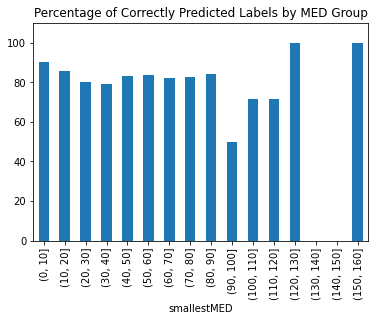

In [19]:
groupedMED.plot(kind='bar', ylim=[0,110], title='Percentage of Correctly Predicted Labels by MED Group')

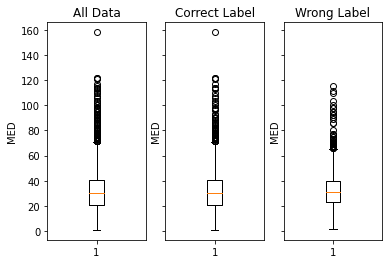

In [25]:

correctlabel_rows = df[df['pred_label'] == df['gold_label']]
wronglabel_rows = df[df['pred_label'] != df['gold_label']]

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True)

ax0.boxplot(df['smallestMED'])
ax0.set_title('All Data')
ax0.set_ylabel('MED')

ax1.boxplot(correctlabel_rows['smallestMED'])
ax1.set_title('Correct Label')
ax1.set_ylabel('MED')

# Plot the box and whisker diagram for non-matching rows
ax2.boxplot(wronglabel_rows['smallestMED'])
ax2.set_title('Wrong Label')
ax2.set_ylabel('MED')

# Show the plots
plt.show()

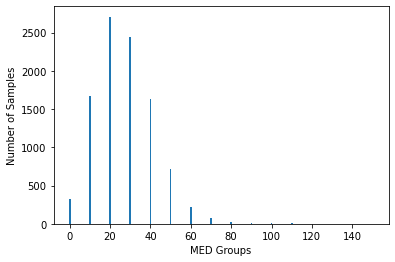

In [24]:
grouped_data = df.groupby('flooredMED').size().reset_index(name='count')

plt.bar(grouped_data['flooredMED'], grouped_data['count'])
plt.xlabel('MED Groups')
plt.ylabel('Number of Samples')
plt.show()